In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from pprint import pprint
from functools import partial
from glob import glob
import cftime
import json
import string

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import drift_functions
import sn_plotting
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Logging
logger = utils.get_notebook_logger()

In [2]:
import listXarray as lxr
reload(lxr)
from listXarray import listXarray

# Opening Data

In [3]:
a1_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', logginglevel='ERROR')
                 .to_dataarray('tas')
                 .sort_by_refkey())

In [4]:
pct_raw_xrlist =  (open_zecmip.extract_experiment_into_xrlist('1pct', 'tas')
                   .to_dataarray('tas')
                   .sort_by_refkey())

In [5]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('esm-piControl', 'tas', logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
- r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-piControl/r1i1p1f1/Amon/tas/gn/v20191115/*.nc
- CanESM5
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
- r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428/*.nc
- UKESM1-0-LL
- r1i1p1f1 - /g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/UKESM1-0-LL/*.nc
- MPI-ESM1-2-LR
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
- r1i1p1f1 - /g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/GISS/*.nc
- CESM2
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190723/*.nc
- NorESM2-LM
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-LM/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190920/*.nc
- GFDL-ESM4
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP

In [6]:
a1_raw_xrlist = a1_raw_xrlist.isel(ensemble=0)
pct_raw_xrlist = pct_raw_xrlist.isel(ensemble=0)
esmpi_raw_xrlist = esmpi_raw_xrlist.isel(ensemble=0)

In [7]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [8]:
esmpi_regrid_xrlist = esmpi_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear')
pct_regrid_xrlist = pct_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear')
a1_regrid_xrlist = a1_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear')

In [9]:
# Making the data yearly
esmpi_xrlist = esmpi_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
pct_xrlist = pct_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
a1_xrlist = a1_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')

In [10]:
# Subsetting to only first 150 years so all models have equal footing
esmpi_xrlist = esmpi_xrlist.isel(time=slice(None, 150))

# Reduce time so that the smalles time densions matches. This is at 101 years
a1_xrlist = a1_xrlist.isel(time=slice(None, 100))
esmpi_xrlist

key_dim = model


Number of da/ds: 9
---------------
['MPI-ESM1-2-LR']({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['ACCESS-ESM1-5']({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['CanESM5']     ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['GFDL-ESM4']   ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['GISS-E2-1-G-CC']({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['MIROC-ES2L']  ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['UKESM1-0-LL'] ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})

In [11]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_xrlist[model], a1_xrlist[model], logginglevel='INFO') for model in pct_xrlist.refkeys]).set_refkeys('model')

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=65
- 

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 

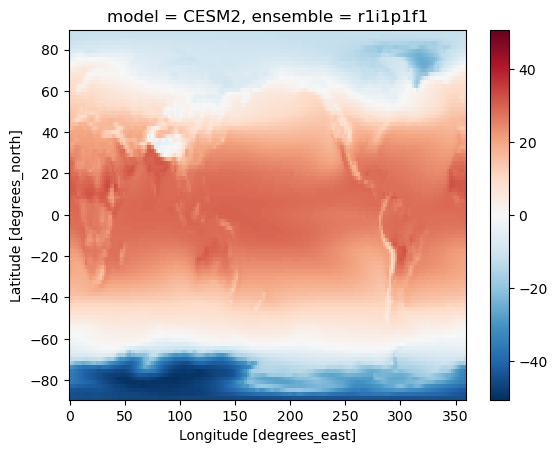

In [12]:
branch_point_mean_xrlist['CESM2'].plot()

In [13]:
# The amomaly time series from the branch point
a1_anom_xrlist = (a1_xrlist - branch_point_mean_xrlist).compute()

In [14]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_xrlist = a1_anom_xrlist.isel(time=slice(15, 35)).mean(dim='time')
zec50_xrlist = a1_anom_xrlist.isel(time=slice(40, 60)).mean(dim='time')
zec50_xrlist

key_dim = model


Number of da/ds: 9
---------------
['MPI-ESM1-2-LR']({'model': 1, 'lat': 96, 'lon': 192})
['ACCESS-ESM1-5']({'model': 1, 'lat': 96, 'lon': 192})
['CESM2']       ({'model': 1, 'lat': 96, 'lon': 192})
['CanESM5']     ({'model': 1, 'lat': 96, 'lon': 192})
['GFDL-ESM4']   ({'model': 1, 'lat': 96, 'lon': 192})
['GISS-E2-1-G-CC']({'model': 1, 'lat': 96, 'lon': 192})
['MIROC-ES2L']  ({'model': 1, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'lat': 96, 'lon': 192})
['UKESM1-0-LL'] ({'model': 1, 'lat': 96, 'lon': 192})

In [21]:
# a1_anom_xrlist = a1_anom_xrlist.apply(utils.reset_time_to_0_start)
# esmpi_xrlist = esmpi_xrlist.apply(utils.reset_time_to_0_start)

# All modles now have matching coordinates - can now be converted to xarray
a1_anom_ds = a1_anom_xrlist.apply(utils.reset_time_to_0_start).concat('model')
pct_ds = pct_xrlist.apply(utils.reset_time_to_0_start).concat('model')
esmpi_ds = esmpi_xrlist.apply(utils.reset_time_to_0_start).concat('model')

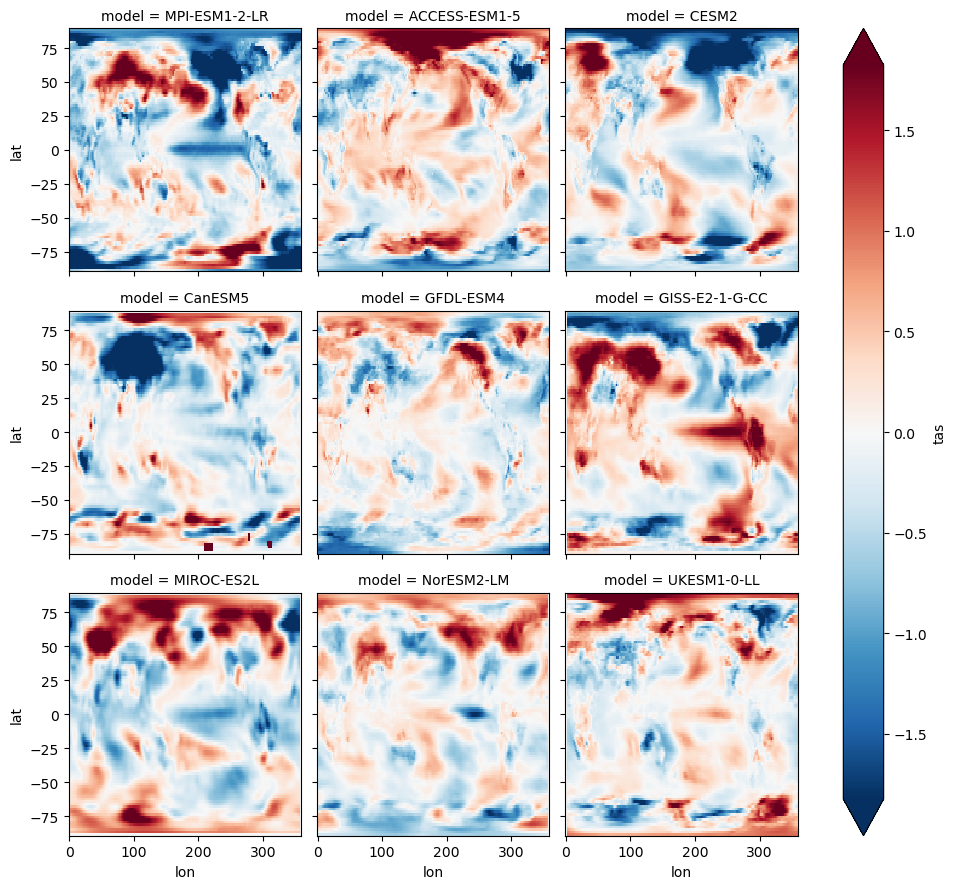

In [30]:
a1_anom_ds.isel(time=0).plot(col='model', robust=True, col_wrap=3)

# SN Calculation

In [31]:
%%time
# Detrend the data
a1_anom_trendfit_ds = stats.trend_fit(a1_anom_ds, method='polynomial', order=3)
a1_anom_detrend_ds = a1_anom_ds - a1_anom_trendfit_ds

CPU times: user 44.4 s, sys: 90.5 ms, total: 44.5 s
Wall time: 44.5 s


In [38]:
%%time
# Rolling
sn_multi_rolling_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_anom_ds.chunk({'model':1}), esmpi_ds.chunk({'model':1}), da_for_noise = a1_anom_detrend_ds.chunk({'model':1}),
    rolling_noise=True, return_all=True, logginglevel='ERROR', windows=[20, 40])


Experiment
--------
20, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

20, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge
CPU times: user 37min 57s, sys: 32min 37s, total: 1h 10min 35s
Wall time: 33min 43s


In [60]:
sn_multi_rolling_ds = sn_multi_rolling_ds.compute()

In [61]:
# This is the length that all of the plots shoudl go to
max_effective_length = len(sn_multi_rolling_ds.time.values) -  40
max_effective_length

60

In [62]:
# Calculate the year that each is stable
rolling_year_stable_ds = sn.get_stable_year_ds(sn_multi_rolling_ds, max_effective_length=max_effective_length).compute()
rolling_year_stable_ds

<xarray.Dataset>
Dimensions:                  (lat: 96, lon: 192, model: 9, window: 2,
                              variable: 1)
Coordinates:
  * lat                      (lat) float64 -88.57 -86.72 -84.86 ... 86.72 88.57
  * lon                      (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * model                    (model) <U14 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
  * window                   (window) int64 20 40
    ensemble                 <U8 'r1i1p1f1'
    forecast_reference_time  object 1850-01-01 00:00:00
  * variable                 (variable) object 'signal_to_noise'
Data variables:
    time                     (variable, window, model, lat, lon) int64 0 ... 44

In [75]:
rollling_year_stable_local_average_ds = xe.get_average_and_uncertainty_across_dim(
    rolling_year_stable_ds, 'model', averaging_method='mean', uncertainty_method='max_min').squeeze()

rollling_year_stable_local_average_ds

- averaging_method='mean', uncertainty_method='max_min'


<xarray.Dataset>
Dimensions:                  (lat: 96, lon: 192, window: 2)
Coordinates:
  * lat                      (lat) float64 -88.57 -86.72 -84.86 ... 86.72 88.57
  * lon                      (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * window                   (window) int64 20 40
    ensemble                 <U8 'r1i1p1f1'
    forecast_reference_time  object 1850-01-01 00:00:00
    variable                 <U15 'signal_to_noise'
Data variables:
    average_value            (window, lat, lon) float64 0.0 0.6667 ... 10.0
    uncertainty              (window, lat, lon) float64 0.0 3.0 ... 22.0 22.0

In [72]:
# # Just the unstalgbe points - both xrlist and ds
above_or_below_kwargs = dict(main_var='signal_to_noise', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_ds = sn_multi_rolling_ds.utils.above_or_below(**above_or_below_kwargs)
# unstable_rolling_ds = sn_multi_rolling_xrlist.mean(dim='ensemble').drop('ensemble').concat('model').utils.above_or_below(**above_or_below_kwargs)

In [77]:
# For each window get the number of years that are stable forn each point in time
decreasing_unstable_ds = xr.where(unstable_rolling_ds < 0, 1, 0)
increasing_unstable_ds = xr.where(unstable_rolling_ds > 0, 1, 0)

In [80]:
increasing_unstable_ds

<xarray.Dataset>
Dimensions:                  (window: 2, model: 9, time: 100, lat: 96, lon: 192)
Coordinates:
  * lat                      (lat) float64 -88.57 -86.72 -84.86 ... 86.72 88.57
  * lon                      (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * model                    (model) <U14 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
  * time                     (time) object 0001-12-31 00:00:00 ... 0100-12-31...
  * window                   (window) int64 20 40
    ensemble                 <U8 'r1i1p1f1'
    forecast_reference_time  object 1850-01-01 00:00:00
Data variables:
    signal_to_noise          (window, model, time, lat, lon) int64 0 0 0 ... 0 0

# Plotting

In [ ]:
NAMING_MAP = dict(gl='Global', nh='Northern Hemisphere', sh='Southern Hemisphere', tropics='Tropics', land='Land', ocean='Ocean',
                 mid_latitudes='Mid Latitudes', arctic='Arctic', antarctic='Antarctic')

In [63]:
levels = np.arange(0, 60, 5)

In [64]:
my_cmap = plotting_functions.create_discrete_cmap('BuPu', levels=levels, add_white=True)

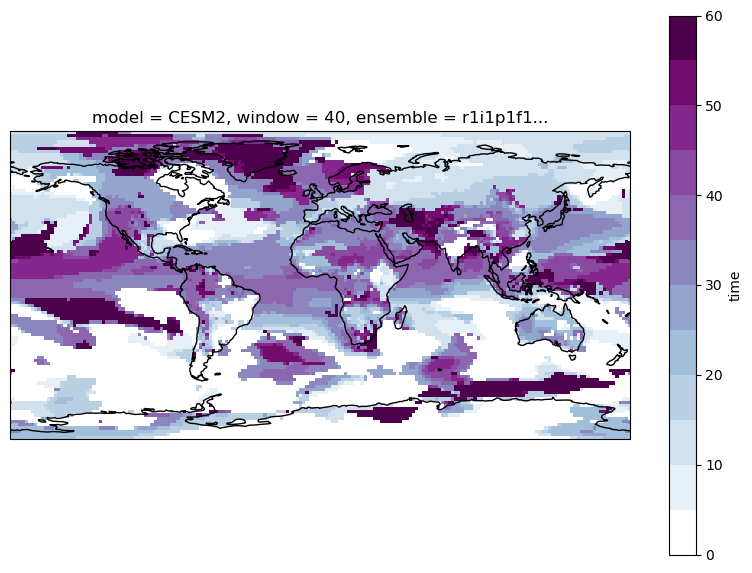

In [65]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
rolling_year_stable_ds.isel(window=1, model=2).time.plot(ax=ax, cmap=my_cmap)
ax.coastlines()

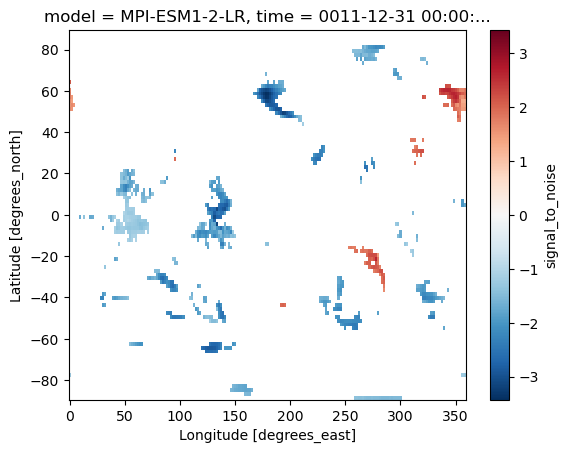

In [73]:
unstable_rolling_ds.isel(window=0, model=0, time=10).signal_to_noise.plot()